# Topological Data Analysis (TDA)

The main tools we will use here are 
1. [UMAP](https://github.com/lmcinnes/umap) for dimensionality reduction and
2. persistence diagrams and bottleneck distances

An accessible introduction to Topological Data Analysis is [A User's Guide to Topoological Data Analysis](https://files.eric.ed.gov/fulltext/EJ1149275.pdf) by Elizabeth Munch. A more thorough introduction is given in this [tutorial](https://arxiv.org/abs/1710.04019).


## Summary 
We plotted the output (total power) of the chillers in a separate notebook. The graphs clearly show that the pattern in the **output**, $y_t$, has changed over the years.

Here, we want to visualize if the **multi-dimensional inputs**, $\mathbf{x}_t \in \mathbb{R}^6$, consisting of the 6 features 
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr",
has changed between year 2006 and 2008.

We use the UMAP dimension reduction algorithm to map these vectors to 2 dimensions so that we can visualize them using scatter plots. The resulting plots of **weekly data** clearly indicate that these sensor readings has changed over the years.

We separately reduce the $\mathbf{x}_t$s to 3 and 4 dimensions and computed persistence diagrams of data from individual days. The bottleneck distance between these persistence diagrams are then computed to get a measure of how different the chiller was over the days. The resulting distance matrix, visualized as a heatmap, shows that the days from 2006 are more similar among themselves than to those in 2008. Furthermore, the individual days of 2008 are not all similar to each other.

Lastly, given these bottleneck distances computed from invidual days, we use MDS to visualize the differences between the days as points on a scatter plot to spot more patterns. We observe that the different homology classes provide us with different information. Points which are considered similar given a homology might be different in another.

How to interpret these differences, in particular how to relate them to actual physical process that took place, is still an open question.

## TODO
We need to clarify with Dr Chai how the $\mathbf{x}_t$s are related to the output power $y_t$.

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh as bk
import gudhi as gd
import umap as um

plt.style.use("ggplot")
%matplotlib inline

## Get raw data

In [2]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

# Assign features and targets
y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Fit UMAP for dimension reduction

We are going to use the first few weeks of 2006 and 2008 to train the UMAP dimensionality reduction algorithm. After that, we will use it to project all points to a lower dimension.

In [3]:
num_2006_weeks = X1.index.weekofyear.nunique()
num_2008_weeks = X2.index.weekofyear.nunique()
num_2006_days = X1.index.dayofyear.nunique()
num_2008_days = X2.index.dayofyear.nunique()
print("# 2006 days: {} # 2006 weeks: {}".format(num_2006_days, num_2006_weeks))
print("# 2008 days: {} # 2008 weeks: {}".format(num_2008_days, num_2008_weeks))
print("# 2006 examples: {} # 2008 examples: {}".format(len(X1), len(X2)))

# 2006 days: 58 # 2006 weeks: 9
# 2008 days: 37 # 2008 weeks: 7
# 2006 examples: 81623 # 2008 examples: 53147


In [9]:
import matplotlib as mpl

def group(X, labels):
    """Group data in X according to their labels."""
    
    grouper = X.groupby(labels)
    keys = sorted(list(grouper.groups.keys()))
    return [grouper.get_group(k) for k in keys]

def fit_umap(X1, X2, y1, y2, n_weeks, **kwargs):
    """Fit UMAP reducer to weekly data"""        
        
    # Group data by week
    g_X1 = group(X1, X1.index.weekofyear)
    g_X2 = group(X2, X2.index.weekofyear)
    g_y1 = group(y1, y1.index.weekofyear)
    g_y2 = group(y2, y2.index.weekofyear)
    
    # Fit UMAP to first n_weeks of data from each year
    X = pd.concat(g_X1[:n_weeks] + g_X2[:n_weeks])        
    reducer = um.UMAP(**kwargs)    
    reducer.fit(X)
    return reducer

def plot_by_week(XX1, XX2, y1, y2, figsize=(12, 18), s=1, alpha=0.5, title=None, 
                 colorby="time", cmap="magma"):
    """ Plot embeddings of points from each week
    """
    
    def plot(axes, X_groups, y_groups, time_groups, weeks, vmin, vmax):
        for ax, X, y, time, week in zip(axes, X_groups, y_groups, time_groups, 
                                        weeks):        
            if colorby == "time":
                c = time
            elif colorby == "power":
                c = y.values

            X = X.values
            ax.scatter(X[:, 0], X[:, 1], c=c, s=s, vmin=vmin, vmax=vmax,
                       alpha=alpha, cmap=cmap)
            ax.set_title("Week {}".format(week))
            
            # Hide grid lines
            ax.grid(False)

            # Hide axes ticks
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_zticks([])
    
    
    assert colorby in ("time", "power")
    
    if colorby == "time":
        vmin = 0
        vmax = 24 * 60**2 + 2 # Number of seconds in a day + padding   
    elif colorby == "power":
        power = pd.concat((y1, y2))
        vmin = power.min()
        vmax = power.max() + 2
        
    week_labels1 = XX1.index.weekofyear
    week_labels2 = XX2.index.weekofyear
        
    X1_groups = group(XX1, week_labels1)
    X2_groups = group(XX2, week_labels2)
    y1_groups = group(y1, week_labels1)
    y2_groups = group(y2, week_labels2)
    
    t1_groups = group(time_of_day_seconds(y1.index), week_labels1)
    t2_groups = group(time_of_day_seconds(y2.index), week_labels2)
    
    n_weeks1 = week_labels1.nunique()
    n_weeks2 = week_labels2.nunique()
    
    fig, axes = plt.subplots(2, max(n_weeks1, n_weeks2), 
                             sharex=True, sharey=True, figsize=figsize)
            
    plot(axes[0], X1_groups, y1_groups, t1_groups,
         np.sort(week_labels1.unique()), vmin, vmax)
    plot(axes[1], X2_groups, y2_groups, t2_groups,
         np.sort(week_labels2.unique()), vmin, vmax)
        
    axes[0][0].set_ylabel("Year 2016", fontsize=14)    
    axes[1][0].set_ylabel("Year 2018", fontsize=14)
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Add colorbar
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cmap.set_array([])
    cbar_ax = fig.add_axes([0.09, 0.01, 0.84, 0.02])
    cbar = fig.colorbar(cmap, cax=cbar_ax, orientation="horizontal", pad=0.2)
    
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])
    if colorby == "time":
        cbar.set_ticklabels(['00AM', '12PM', '12AM'])
    elif colorby == "power":
        cbar.set_ticklabels(["{:.0f} KW".format(p) 
                             for p in (vmin, (vmin + vmax) / 2, vmax)])
        
    if title is not None:
        fig.suptitle(title, fontsize=14)            
    
    return fig

def time_of_day_seconds(time_index):
    return time_index.to_series().map(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

## Visualize projections grouped by week

### Color by time of day

We group the data projected by UMAP onto 2 dimensions by the **week** they belong to and plot them in the following plots. Colors correspond to the time of day a point was collected.

In [5]:
reducer = fit_umap(X1, X2, y1, y2, 
                   n_weeks=3, n_components=2, 
                   random_state=123, min_dist=0.01)

# Embed points
XX1 = reducer.transform(X1)
XX2 = reducer.transform(X2)
XX1 = pd.DataFrame(XX1, index=X1.index)
XX2 = pd.DataFrame(XX2, index=X2.index)

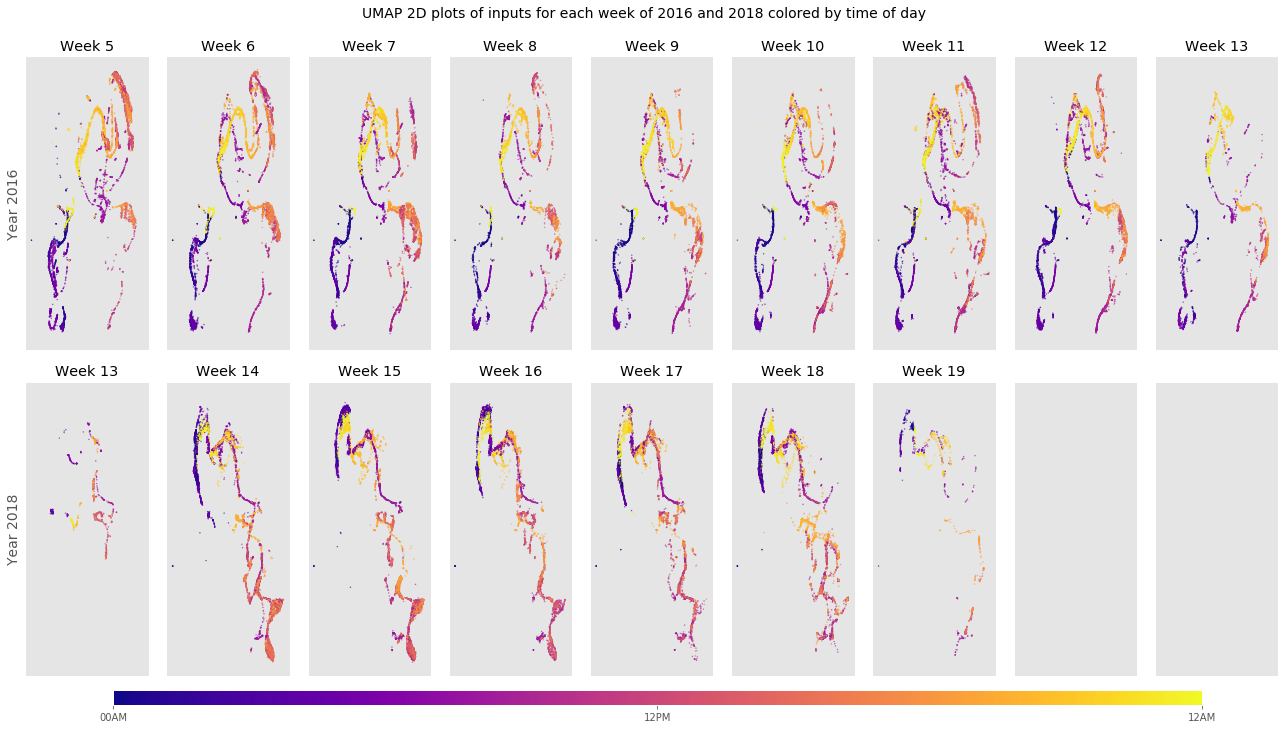

In [10]:
fig = plot_by_week(XX1, XX2, y1, y2, figsize=(18, 10), 
                   title="UMAP 2D plots of inputs for each week"\
                   " of 2016 and 2018 colored by time of day",
                   colorby="time", cmap="plasma");

In [11]:
fig.savefig("umap-plots.png", dpi=300)

As a reminder, each $\mathbf{x}_t$ represents the observed quantities for [chwshdr, cwrhdr, cwshdr, cwsfhdr, loadsys, chwsfhdr] at time $t$.

The plots suggests the following
1. The observed inputs $\mathbf{x}_t$s from year 2006 overall are different from those from 2008.
2. In particular, the observations in 2006 night time (**near and after midnight**) are different from those in 2008. There seems to be some extra "activity" after midnight for 2006 that is not present in 2008.  
3. These readings vary throughout the day but are similar to those close in time. Note that from the 1 dimensional plots of the power we know the **output power**, $y_t$ are similar close in time, but these plots says that the **inputs** are also similar.
4. Note the brightest yellow mix with the darkest purple in some parts. This is because one is 12AM and the other is 00AM. In 2006, after 12AM. For 2006, midnight is a "cutoff" point when the system transition into a different state (bottom left purple region) that we do not see in 2008.

Next, we color these plots using the power instead of time.

### Color by output power

The following are the same plots as above except color here correspond to the total power output for that point.

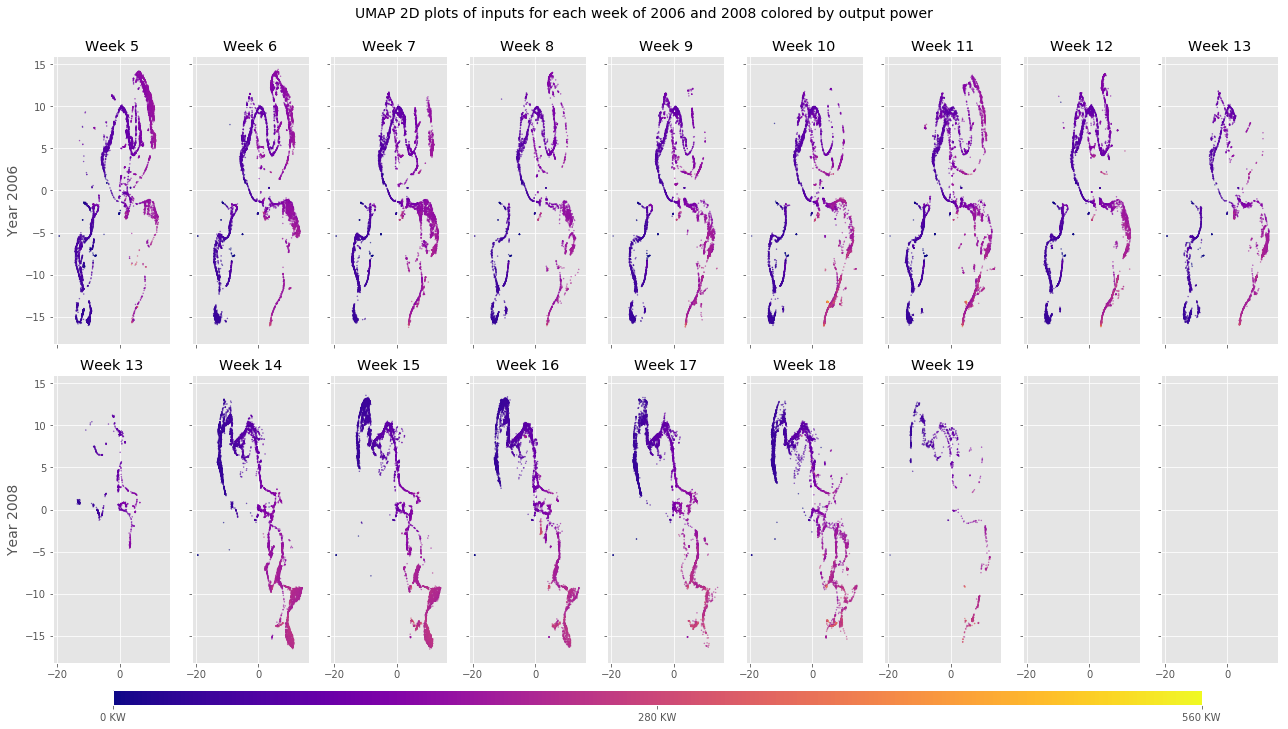

In [10]:
fig = plot_by_week(XX1, XX2, y1, y2, figsize=(18, 10), 
                   title="UMAP 2D plots of inputs for each week"\
                   " of 2006 and 2008 colored by output power",
                   colorby="power", cmap="plasma");

1. We also notice that the inputs that leads to the larger power (bottom and top right half) are different from those for smaller power. By referencing the earlier plots colored by time, we can infer that these regions corresponds roughly to noon till early evening and near and after midnight, just as we expect.
2. What it tells us is that roughly the $\mathbf{x}_t$s corresponding to larger power are different from those for smaller ones. This is a good thing as it means the features that make up individual $\mathbf{x}_t$ contain relevant information.


## Quantify differences between days

We group points by the day they are collected on and measure the similarity of these points using TDA tools.

In [210]:
# def compute_persistence(X, max_edge_length=0.5, max_dim=1, complex_type="rips"):
def compute_persistence(X, max_edge_length=2, max_dim=1, complex_type="rips"):    
    """Compute persistence diagram"""
    
    allowed_types = ("rips", "alpha") #, "witness") # Don't use witness complex for the moment.
    assert complex_type in allowed_types,\
           "complex_type must be one of {}".format(allowed_types)
    
    if complex_type == "rips":
        sim_complex = gd.RipsComplex(points=X.tolist(), max_edge_length=max_edge_length)
        simplex_tree = sim_complex.create_simplex_tree(max_dimension=max_dim)
    elif complex_type == "alpha":
        sim_complex = gd.AlphaComplex(points=X.tolist())
        simplex_tree = sim_complex.create_simplex_tree() # TODO: Take in max alpha squared
        
    diag = simplex_tree.persistence()
    return sim_complex, simplex_tree, diag

def pairwise_bottleneck_dist(X, dim=0, eta=0.01):
    """Compute pairwise bottleneck distances.
    """
    N = len(X)
    dist = np.zeros((N, N))
    for i in range(N):
        simtree_i = X[i]    
        for j in range(i + 1, N):
            simtree_j = X[j]
            dist[i, j] = gd.bottleneck_distance(simtree_i.persistence_intervals_in_dimension(dim),
                                                simtree_j.persistence_intervals_in_dimension(dim),
                                                eta)
    return dist


import scipy as sp
from bokeh.palettes import Blues9
from bokeh.io import output_notebook, show
from bokeh.models import (ColumnDataSource, HoverTool, 
                          LinearColorMapper, Legend, ColorBar,
                          CategoricalTicker)
from bokeh.palettes import plasma, RdYlGn, viridis, Blues9
from bokeh.plotting import figure
from bokeh.transform import transform

output_notebook()

def plot_distance_matrix(D, labels, title, figsize=(800, 800)):
    """Interactive distance matrix plot made using Bokeh"""
    
    assert len(D) == len(labels), "Length must match"
        
    p = figure(plot_width=figsize[0], plot_height=figsize[1],
               title=title,
               x_range=labels, 
               y_range=list(reversed(labels)),
               tools="hover,save",
               toolbar_location="below",               
               tooltips=[('Date', '@y - @x'), ('Distance', '@distance')],
               x_axis_type=None)
 
    # Flatten pairwise distance matrix
    df = pd.DataFrame(D, columns=labels, index=labels).stack().reset_index()                
    df.columns = ["x", "y", "distance"]
    source = ColumnDataSource(df)
    mapper = LinearColorMapper(palette=Blues9, low=df.distance.min(), high=df.distance.max())
    p.rect('x', 'y', 0.9, 0.9, 
           source=source,
           fill_color={'field': 'distance', 'transform': mapper},
           line_color=None,
           hover_line_color='black')
    
    p.yaxis.major_label_text_font_size = "6pt"    
    color_bar = ColorBar(color_mapper=mapper, #ticker=LogTicker(),
                         label_standoff=12, border_line_color=None, location=(0,0))
    p.add_layout(color_bar, 'right')

    bk.plotting.show(p)

import seaborn as sn
def plot_distance_matrix_static(D, labels, annot=True, figsize=(12, 12), 
                                title=None, cmap="plasma"):
    """Plot matrix color coded by value and labeled by entries.
    Taken from: https://stackoverflow.com/questions/35572000/
    how-can-i-plot-a-confusion-matrix
    """
    df_cm = pd.DataFrame(D, index=labels,
                         columns=labels)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    cbar_ax = fig.add_axes([0.09, 0.01, 0.84, 0.02])

    sn.heatmap(df_cm, square=True, annot=annot, cmap=cmap,
               ax=ax,
               cbar_ax=cbar_ax,
               cbar_kws={"orientation": "horizontal", "pad": 0.2})
    
    for tick in fig.axes[0].get_yticklabels():
        tick.set_rotation(0)
        
    fig.axes[0].get_xaxis().set_visible(False)
    for tick in fig.axes[0].yaxis.get_major_ticks():
        tick.label1.set_verticalalignment('center')
        
    # Gridlines based on minor ticks
    fig.axes[0].grid(which='minor', color='w', linestyle='-', linewidth=2)
    fig.axes[0].grid(True)
        
    fig.axes[0].set_xlabel("Year and Day of year")
    fig.axes[0].set_ylabel("Year and Day of year")

Loading BokehJS ...

### Compute persistence diagrams from daily data

A persistence diagram can be considered a topological descriptor (it is actually more than a descriptor but we omit the details). It describes the topological features of a set of points/vectors. 

We compute a persistence diagram from the points collected from each day.

In [211]:
# We retain 3 dimensions here instead of 2 so that we keep more information
reducer = fit_umap(X1, X2, y1, y2, 
                   n_weeks=3, n_components=3, 
                   random_state=123, min_dist=0.01)

# Embed points
XX1 = reducer.transform(X1)
XX2 = reducer.transform(X2)
XX1 = pd.DataFrame(XX1, index=X1.index)
XX2 = pd.DataFrame(XX2, index=X2.index)

# Group data by day
X1_groups = group(XX1, XX1.index.dayofyear)
X2_groups = group(XX2, XX2.index.dayofyear)

# Compute alpha simplicial complex and persistence diagrams for 2016 and 2018 data
d2016_day_alpha = [compute_persistence(x.values, max_dim=2, complex_type="alpha")
                   for x in X1_groups]
d2018_day_alpha = [compute_persistence(x.values, max_dim=2, complex_type="alpha")
                   for x in X2_groups]

In [138]:
# We retain 4 dimensions here instead of 2 so that we keep more information
reducer = fit_umap(X1, X2, y1, y2, 
                   n_weeks=3, n_components=4, 
                   random_state=123, min_dist=0.01)

# Embed points
XX1 = reducer.transform(X1)
XX2 = reducer.transform(X2)
XX1 = pd.DataFrame(XX1, index=X1.index)
XX2 = pd.DataFrame(XX2, index=X2.index)

# Group data by day
X1_groups = group(XX1, XX1.index.dayofyear)
X2_groups = group(XX2, XX2.index.dayofyear)

# Compute alpha simplicial complex and persistence diagrams for 2016 and 2018 data
d2016_day_alpha = [compute_persistence(x.values, max_dim=2, complex_type="alpha")
                   for x in X1_groups]
d2018_day_alpha = [compute_persistence(x.values, max_dim=2, complex_type="alpha")
                   for x in X2_groups]

### Compute pairwise bottleneck distances

Given the persistence diagrams computed above, we can compute a distance between each pair of diagram. This distance is known as bottleneck distance and it gives us a measure of similarity between the data from different days.

We compute pairwise bottleneck distance for 0, 1, and 2-dimensional homology.
0-dimensional homology measures topological features from connected components formed from the points, 1-dimensional for loops, and 2-dimensional for voids.

Roughly speaking, the more dimensions of homology two sets of points are close to each other, the more similar they are to each other.

In [212]:
X = [d[1] for d in d2016_day_alpha] + [d[1] for d in d2018_day_alpha]
d1 = pairwise_bottleneck_dist(X, dim=0)
d2 = pairwise_bottleneck_dist(X, dim=1)
d3 = pairwise_bottleneck_dist(X, dim=2)

D0 = d1 + d1.T
D1 = d2 + d2.T
D2 = d3 + d3.T

### Visualize distance matrix

We first consider the distance between a point as the maximum pairwise distance across 0 and 1-dimensional homology for $\mathbf{x}_t$s reduced to **3 dimensions** using UMAP. 

Note the labeling of the y-axis (distance metric is symmetric so we only consider one side). 16d32 means year 2016, day 32 of the year. 

#### For 3 dimensional vectors

In [213]:
timestamps = group(XX1.index.to_series(), XX1.index.dayofyear) +\
             group(XX2.index.to_series(), XX2.index.dayofyear)
timestamps = [t[0].strftime("%a %d/%b/%y") for t in timestamps]

plot_distance_matrix(D0, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (0 dim homology from 3 dim vectors)", 
                     figsize=(750, 750))

In [214]:
plot_distance_matrix(D1, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (1 dim homology from 3 dim vectors)", 
                     figsize=(750, 750))

In [215]:
plot_distance_matrix(D2, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (2 dim homology from 3 dim vectors)", 
                     figsize=(750, 750))

**Hover mouse over a square to see the 2 days being compared.**

Here we see that after we include information from 2-dimensional homology, we are able to detect 2 days in 2016 that are very different from the other days. Likewise, there are also a few days in 2018 when the chiller operated very differently from the other days in that year. 

These anomalies were not detectable from using information only from 0 and 1-dimensional homology.

<font color="red">**NOTE:** </font> Some anomalies or patterns are spurious because we computed the persistence diagrams from the inputs that have already been reduced to 3 dimension instead of operating on the original 6 dimensional data. The reason we did this is because computing the persistent diagrams using the original 6 dimensional data took too much time.

Below, we use UMAP to project to **4** dimensions (1 more than the above) and perform the same steps as above. The goal is to see if having an extra dimension will affect the results or lead to **significantly** different conclusions.

#### For 4 dimensional vectors

In [203]:
timestamps = group(XX1.index.to_series(), XX1.index.dayofyear) +\
             group(XX2.index.to_series(), XX2.index.dayofyear)
timestamps = [t[0].strftime("%a %d/%b/%y") for t in timestamps]

plot_distance_matrix(D0, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (0 dim homology from 4 dim vectors)", 
                     figsize=(750, 750))

In [204]:
plot_distance_matrix(D1, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (1 dim homology from 4 dim vectors)", 
                     figsize=(750, 750))

In [205]:
plot_distance_matrix(D2, timestamps,
                     "Bottleneck distance between daily inputs"\
                     " of 2016 and 2018 (2 dim homology from 4 dim vectors)", 
                     figsize=(750, 750))

Comparing the corresponding plots for 3 and 4 dimensions, the result look very similar for 0 and 1 dimensional homology but different for 2 dimensional homology. We now use MDS to transform these pairwise distances into a scatter plot so that it is easier to discern any patterns in there.

### Visualize MDS projections

We now visualize these days as points using Metric Multi-dimensional Scaling (MDS). This will help us spot other patterns in the distance matrix.

In [206]:
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, Legend
from bokeh.palettes import plasma, RdYlGn, viridis, Blues9
from bokeh.plotting import figure
from bokeh.transform import transform

%matplotlib notebook

output_notebook()

def plot_points(X, timestamps, title, plot_width=400, plot_height=400):
    x = X[:, 0]
    y = X[:, 1]
    desc = np.asarray([t.strftime("%a %d-%b-%y") for t in timestamps])    
    weekend = np.asarray([t.dayofweek >= 5 for t in timestamps])
    years = np.asarray([t.year for t in timestamps])
    epoch = sorted(timestamps)[0]
    time_seconds = np.asarray([(t - epoch).total_seconds() for t in timestamps])    
    hover = HoverTool(tooltips=[("index", "$index"),                                
                                ('desc', '@desc')])
    
    mapper = LinearColorMapper(palette=Blues9, low=min(time_seconds), high=max(time_seconds))
    p = figure(plot_width=plot_width, plot_height=plot_height,
               toolbar_location="below",
               tools=[hover], title=title)
    
    legend_items = []
    for year in np.unique(years):
        mask = years == year
        mask_weekday = mask & ~weekend
        mask_weekend = mask & weekend
        source_weekday = ColumnDataSource(data=dict(x=x[mask_weekday], 
                                                    y=y[mask_weekday],
                                                    desc=desc[mask_weekday],
                                                    time_seconds=time_seconds[mask_weekday]))
        c = p.circle('x', 'y', size=10, source=source_weekday,
                     fill_color=transform('time_seconds', mapper),
                     fill_alpha=0.6)        
        legend_items.append(("Year {} (Weekday)".format(year), [c]))
        
        source_weekend = ColumnDataSource(data=dict(x=x[mask_weekend], 
                                                    y=y[mask_weekend],
                                                    desc=desc[mask_weekend],
                                                    time_seconds=time_seconds[mask_weekend]))
        c = p.triangle('x', 'y', size=10, source=source_weekend,
                       fill_color=transform('time_seconds', mapper),
                       fill_alpha=0.6)
        legend_items.append(("Year {} (Weekend)".format(year), [c]))

    legend = Legend(items=legend_items, location=(0, 100))
    legend.click_policy = "hide"
    p.add_layout(legend, 'right')    
    bk.plotting.show(p)

Loading BokehJS ...

#### For 3 dimensional vectors

In [216]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, n_init=50, n_jobs=4, 
          random_state=123456, dissimilarity="precomputed")
mds.fit(D0)
timestamps = group(XX1.index.to_series(), XX1.index.dayofyear) +\
             group(XX2.index.to_series(), XX2.index.dayofyear)
# Grab first timestamp of each day to represent day
timestamps = [t[0] for t in timestamps]
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (0 dim homology from 3 dim vectors)", 
            plot_width=720, plot_height=500)

In [217]:
mds.fit(D1)
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (1 dim homology from 3 dim vectors)", 
            plot_width=720, plot_height=500)

In [218]:
mds.fit(D2)
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (2 dim homology from 3 dim vectors)", 
            plot_width=720, plot_height=500)

#### For 4 dimensional vectors

In [207]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, n_init=50, n_jobs=4, 
          random_state=123456, dissimilarity="precomputed")
mds.fit(D0)
timestamps = group(XX1.index.to_series(), XX1.index.dayofyear) +\
             group(XX2.index.to_series(), XX2.index.dayofyear)
# Grab first timestamp of each day to represent day
timestamps = [t[0] for t in timestamps]
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (0 dim homology from 4 dim vectors)", 
            plot_width=720, plot_height=500)

In [208]:
mds.fit(D1)
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (1 dim homology from 4 dim vectors)", 
            plot_width=720, plot_height=500)

In [209]:
mds.fit(D2)
plot_points(mds.embedding_, timestamps,
            "MDS embeddings of days in 2016 and 2018 (2 dim homology from 4 dim vectors)", 
            plot_width=720, plot_height=500)

**Hover the mouse over a point** to see more information about the day. Click on the legend to toggle visibility of a set of points.

When we examine the plots generated from the bottleneck distances computed using **0-dimensional homology** information, it is clear that the $\mathbf{x}_t$s from the two years are mostly different except for a small group of points from 2018.

There is roughly 2 clusters (maybe 3) for the 2016 data. 

2018 data has more variations. Some of them are fairly similar to 2016 data.

The plots also suggests there are a number of anomalies - points that are not close to any group.
A few of them are

| 2016  |  2018 | 
|---|---|
| 11 Feb  | 10 Apr  |
| 21 Feb  | 12 Apr  |
| 19 Mar  | 18 Apr  |
| 21 Mar  |   |
| 23 Mar  |   |

Information from different homology gives different "perspective" on the data. Points that are considered close for some homology might be different when considering a different class of homology.

**Note:** Changing the random seed and number of random initialization for the MDS algorithm will change the result. In particular, the plots may end up getting rotated or the result might differ slightly. This is OK because MDS does not care about the actual coordinate. It only tries to ensure that points that have small bottleneck distances (computed above) should be mapped close to each other and points with large distance between them be mapped far apart.

To put it simply, what you care about is the relative position of the points. Plots which are more or less the same **up to rotation** are approximately the same.

Also, the above two set of plots are generated from the vectors that were reduced by UMAP to 3 and 4 dimensions respectively. Changing the settings of UMAP and the number of dimensions might change the result slightly as well.